In [1]:
from netCDF4 import Dataset
import numpy as np
import eofs
import tqdm
import matplotlib.pyplot as plt
import jupyterthemes
import seaborn as sns
from jupyterthemes import jtplot

In [2]:
jupyterthemes.jtplot.style('onedork')
sns.set()

# No execution needed, variable will be loaded later

In [3]:
gdp = Dataset('data/GDP_per_capita_PPP_1990_2015_v2_2.nc', 'r')
print(gdp)
gdp.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    creation_date: 02-Aug-2017 14:29:40
    resolution: 5 arc-min
    projection: WGS84
    extent: lat: 90�S - 90�N; lon: 180�E - 180�W
    product: Gross Domestic Production (GDP) per capita (PPP) for years 1990-2015
    citation: When using the data, please refer to following publication: TBA
    more information: For more information, see: TBA
    dimensions(sizes): longitude(4320), latitude(2160), time(26)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float32 time(time), float32 GDP_per_capita_PPP(time,latitude,longitude)
    groups: 



In [4]:
gdp.variables['GDP_per_capita_PPP']
lons = gdp.variables['longitude'][:]
lats = gdp.variables['latitude'][:]
gdp_data = gdp.variables['GDP_per_capita_PPP'][:,:,:].data
years = gdp.variables['time'][:]
print('num longitudes : ', len(lons))
print('num latitudes : ', len(lats))
print('gdp shape : ', gdp_data.shape)
print('Years : ', years)
print(type(gdp_data))

num longitudes :  4320
num latitudes :  2160
gdp shape :  (26, 2160, 4320)
Years :  [1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001.
 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013.
 2014. 2015.]
<class 'numpy.ndarray'>


## Let's look at the variables contained here

In [3]:
import sys
import pickle
# gdp_arr = pickle.load( open('./data/GDP_per_capita_PPP_1990_2015_data.pkl', 'rb'))
lons = pickle.load( open('./data/GDP_per_capita_PPP_1990_2015_lons.pkl', 'rb'))
lats = pickle.load( open('./data/GDP_per_capita_PPP_1990_2015_lats.pkl', 'rb'))
years = pickle.load( open('./data/GDP_per_capita_PPP_1990_2015_years.pkl', 'rb'))
gdp_masked = pickle.load(open('/home/armaan/Desktop/gdp_masked.pkl', 'rb'))
solver = pickle.load(open('/home/armaan/Desktop/eof_solver_gdp_masked.pkl', 'rb'))

## Let's understand EOFs in detail
* What's EOF? - Empirical Orthogonal Function (EOF) analysis is to simplify a spatial-temporal data set by transforming it to spatial patterns of variability and temporal projections of these patterns. The spatial patterns are the EOFs, and can be thought of as basis functions in terms of variance. The associated temporal projections are the pricipal components (PCs) and are the temporal coefficients of the EOF patterns.
* What does it give? - 
    * Spatial patterns - similar as image
    * Temporal coefficients of these spatial patterns
* How can we interpret it?
    * Spatial patterns give 

In [5]:
def correct_orient(data):
    """
    reinverts to plot correctly (human)
    """
    return data[:, :]
import copy
def get_data_as_np_array(cdf_data):
    """
    1. construct np array : timexlatxlong
    2. Fixes orientation
    """
    data_arr = []
    for i in tqdm.tqdm(range(26)):
        data = copy.deepcopy(cdf_data.variables['GDP_per_capita_PPP'][i,:,:].data)
        data_arr.append(correct_orient(data))
    return np.array(data_arr)
gdp_arr = get_data_as_np_array(gdp)

import sys
import pickle
pickle.dump(gdp_arr, open('./data/GDP_per_capita_PPP_1990_2015_data.pkl', 'wb'))
pickle.dump(lons, open('./data/GDP_per_capita_PPP_1990_2015_lons.pkl', 'wb'))
pickle.dump(lats, open('./data/GDP_per_capita_PPP_1990_2015_lats.pkl', 'wb'))
pickle.dump(years, open('./data/GDP_per_capita_PPP_1990_2015_years.pkl', 'wb'))

100%|██████████| 26/26 [00:05<00:00,  4.76it/s]


In [10]:
gdp_3d_mask = np.zeros(gdp_arr.shape, dtype=bool)

gdp_3d_mask[:,:,:] = gdp_arr[0][np.newaxis, :, :] == -9.0

gdp_masked = np.ma.array(gdp_arr, mask=gdp_3d_mask)

mean = np.ma.mean(gdp_masked, axis=0)

In [22]:
from eofs.standard import Eof
import importlib as imp
# imp.reload(Eof)
# ?Eof
solver = Eof(gdp_masked, center=True)

In [7]:
spatial_components = solver.eofs()

In [6]:
spatial_components = solver.eofs()
spatial_components[0]

array([[ 1.4675350e-13, -4.8345286e-14, -2.1148317e-14, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [6]:
pc_time = solver.pcs()
dims = (len(lats), len(lons))
var_frac = solver.varianceFraction()
print("Shape of spatial compenents (timexlongxlat) = ", spatial_components.shape)
print("Shape for time components : ", pc_time.shape)
fig, ax = plt.subplots()
ax.plot(range(len(var_frac)), 100*var_frac)
ax.set_title("Percentage of captured variance per EOF component")
ax.set_xlabel("Component number")
ax.set_ylabel("Fraction of var captured")
plt.savefig('./plots/EOF/variance_capture_plot.png', format='png', dpi=1000)

NameError: name 'spatial_components' is not defined

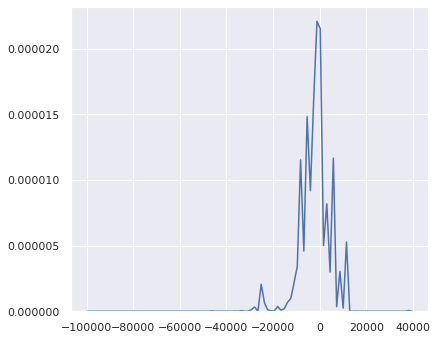

In [106]:
sns.kdeplot(gdp_mean_cetntered_masked_array[0].flatten())

In [28]:
type(gdp_masked[0])

numpy.ma.core.MaskedArray

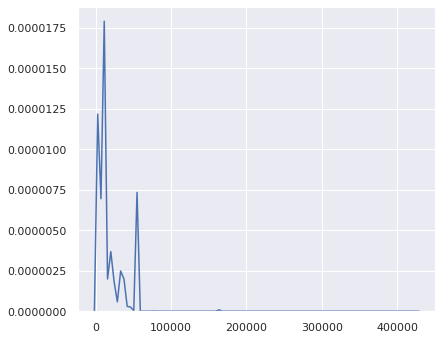

In [25]:
sns.kdeplot(gdp_masked[3].flatten())

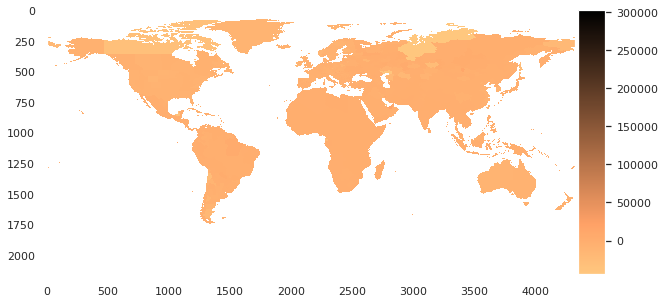

In [112]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
component_number = 3
fig, ax = plt.subplots(figsize = (10, 10))
cmap = plt.cm.copper_r
cmap.set_bad('white',1.)
im = ax.imshow(gdp_masked[component_number], cmap=cmap)
ax.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax)
# plt.savefig('component_{}.png'.format(component_number), dpi=500)

## Let's plot this data using basemap
imshow may not be the best tool to view these, let's try basemap instead

In [12]:
print(type(vals))
np.sum(vals.mask)
# spatial_components[i,:,:].squeeze().shape

NameError: name 'vals' is not defined

In [26]:
spatial_components = solver.eofsAsCovariance()

In [29]:
type(spatial_components[0])

numpy.ma.core.MaskedArray


  0%|          | 0/1 [00:00<?, ?it/s]/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


4320 2160


/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

100%|██████████| 1/1 [00:36<00:00, 36.34s/it]

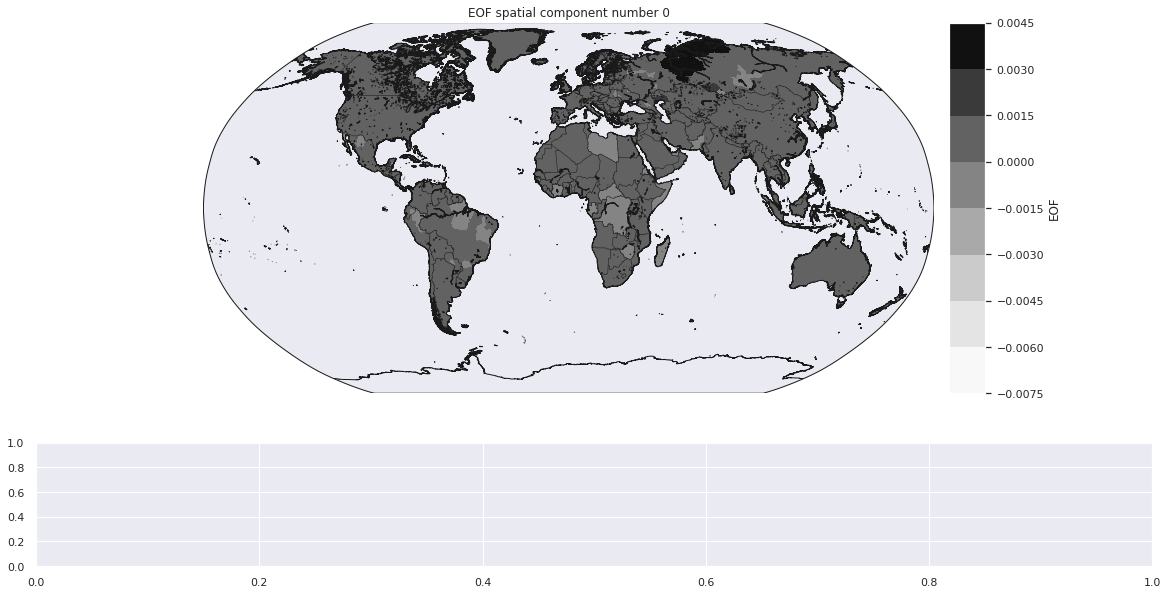

In [33]:
from mpl_toolkits.basemap import Basemap, maskoceans
for i in tqdm.tqdm(range(1)):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30, 20), gridspec_kw={'height_ratios': [3, 1]})
    print(len(lons), len(lats))
    m = Basemap(projection='robin', 
#                 llcrnrlon=min(lons),
#                 llcrnrlat=min(lats),
#                 urcrnrlon=max(lons),
#                 urcrnrlat=max(lats),
                lon_0 = 0,
                lat_0 = 0,
                ax=ax[0],
#                 width=10,
               resolution = 'h')
    x, y = m(*np.meshgrid(lons, lats))
    vals = maskoceans(x, y, spatial_components[i].squeeze())
#     clevs = np.linspace(np.min(vals), np.max(vals), 50)
    cs = m.contourf(x, y, vals, cmap = plt.cm.Greys)
    m.drawcoastlines()
    m.drawcountries()
    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    ax[0].set_title('EOF spatial component number {}'.format(i))
#     ax[1].set_title('EOF ' + str(i+1), fontsize=16)
#     ax[1].plot(years, pc_time[:,i], linewidth=2)
#     ax[1].set_title('Temporal coefficient for EOF_{} over time'.format(i))
#     ax[1].set_xlabel('Measurement Year')
#     ax[1].set_ylabel('Coefficient value')
# #     ax[1].set_facecolor('xkcd:salmon')
#     plt.savefig('./plots/EOF/EOF_{}.png'.format(i), format='png', dpi = 1000)

In [40]:
plt.rcParams['savefig.facecolor'] = 'white'

## Digression 1:
* meshgrid is used for running functions over a grid

In [90]:
import math
X, Y = np.meshgrid(np.linspace(0, 2*math.pi, 10), np.linspace(0, 2*math.pi, 10))
def sin2d(x, y):
    return np.sin(x) + np.sin(y)
z = sin2d(X, Y)
print(z.shape)
# plt.imshow(z)

(10, 10)


## Get principal components of GDP data

/home/armaan/anaconda3/envs/_py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'dpi'
  s)
/home/armaan/anaconda3/envs/_py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'dpi'
  s)
/home/armaan/anaconda3/envs/_py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'dpi'
  s)
/home/armaan/anaconda3/envs/_py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'dpi'
  s)


Text(0.5, 1.0, 'Year 2005')

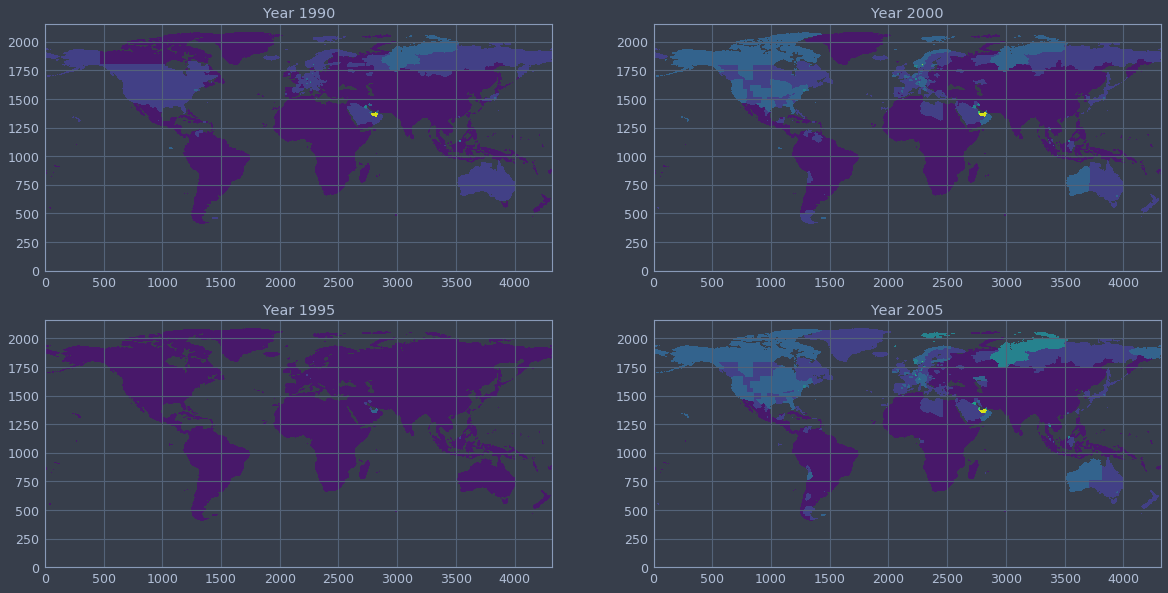

In [7]:
# plt.contourf(gdp.variables['GDP_per_capita_PPP'])
fig, ax = plt.subplots(2,2,figsize=(20,10))
times = [0, 4, 9, 13]
ax[0,0].contourf(gdp.variables['GDP_per_capita_PPP'][0][::-1, :], dpi=300)
ax[0,0].set_title("Year 1990")
ax[1,0].contourf(gdp.variables['GDP_per_capita_PPP'][4][::-1, :], dpi=300)
ax[1,0].set_title("Year 1995")
ax[0,1].contourf(gdp.variables['GDP_per_capita_PPP'][9][::-1, :], dpi=300)
ax[0,1].set_title("Year 2000")
ax[1,1].contourf(gdp.variables['GDP_per_capita_PPP'][13][::-1, :], dpi=300)
ax[1,1].set_title("Year 2005")

plots/gdp_per_capita_global_1990.eps
plots/gdp_per_capita_global_1991.eps
plots/gdp_per_capita_global_1992.eps
plots/gdp_per_capita_global_1993.eps
plots/gdp_per_capita_global_1994.eps
plots/gdp_per_capita_global_1995.eps
plots/gdp_per_capita_global_1996.eps
plots/gdp_per_capita_global_1997.eps
plots/gdp_per_capita_global_1998.eps
plots/gdp_per_capita_global_1999.eps
plots/gdp_per_capita_global_2000.eps
plots/gdp_per_capita_global_2001.eps
plots/gdp_per_capita_global_2002.eps
plots/gdp_per_capita_global_2003.eps
plots/gdp_per_capita_global_2004.eps
plots/gdp_per_capita_global_2005.eps
plots/gdp_per_capita_global_2006.eps
plots/gdp_per_capita_global_2007.eps
plots/gdp_per_capita_global_2008.eps
plots/gdp_per_capita_global_2009.eps
plots/gdp_per_capita_global_2010.eps
plots/gdp_per_capita_global_2011.eps
plots/gdp_per_capita_global_2012.eps
plots/gdp_per_capita_global_2013.eps
plots/gdp_per_capita_global_2014.eps


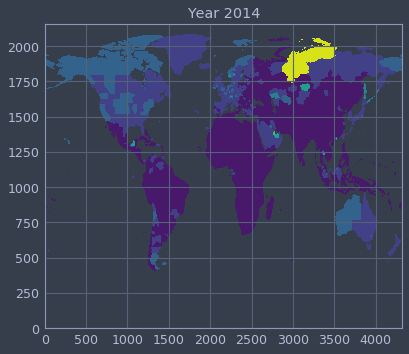

In [122]:
for i, year in zip(range(0, 25), list(gdp.variables['time'][:])):
    year=int(year)
    plt.contourf(gdp.variables['GDP_per_capita_PPP'][i][::-1, :])
    plt.title('Year {:04d}'.format(year))
    f_name = 'plots/gdp_per_capita_global_{:04d}.eps'.format(year)
    plt.savefig(f_name, format='eps', dpi=3000)
    print(f_name)

In [113]:
print("{:02d}".format(4))

04


In [79]:
import os
import imageio
images = []
base_path = '/home/armaan/Desktop/projects/grid_gdp_analysis/plots/'
filenames = os.listdir(base_path)
for filename in filenames:
    images.append(imageio.imread(os.path.join(base_path, filename)))
imageio.mimsave('global_gdp.gif', images)

/home/armaan/anaconda3/envs/_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/armaan/anaconda3/envs/_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


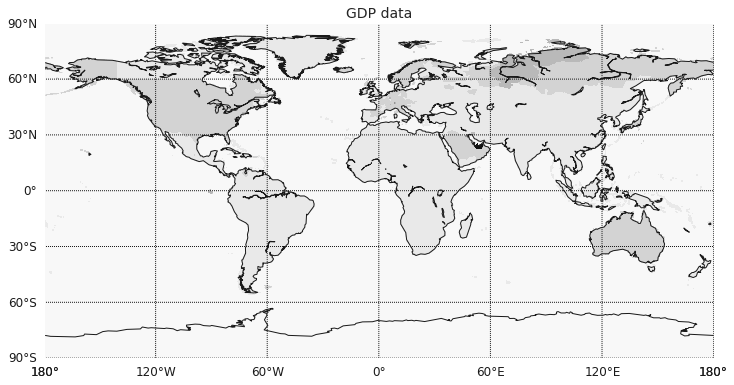

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=[12,15])  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax.set_title('GDP data', fontsize=14)
llons, llats = np.meshgrid(lons, lats)
# x,y = map(llons,llats)
map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c', ax=ax)
map.drawcoastlines()
# map.fillcontinents(color='#ffe2ab')
# draw parallels and meridians.
map.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
map.contourf(llons, llats, gdp_data[::-1,:], cmap='Greys')

In [32]:
obj = gdp.variables['GDP_per_capita_PPP']
for var in gdp.variables.values():
    print(var)
# print(obj)
# obj.variables

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (4320,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (2160,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    standard_name: Time
    long_name: Time
    units: year
    calendar: standard
unlimited dimensions: 
current shape = (26,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 GDP_per_capita_PPP(time, latitude, longitude)
    long_name: Gross Domestic Production (GDP) per capita (PPP)
    units: constant 2011 international US dollar
    missing_value: -9.0
unl